In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, ELU, Dropout, Lambda, Conv2D, Lambda, Input, MaxPooling2D, Activation, BatchNormalization, RandomContrast
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


2023-05-31 13:26:33.784030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#  Dataset

In [2]:
target_folder = 'UdacityDS/self_driving_car_dataset_jungle/'
img_folder = os.path.join(target_folder, 'IMG')
csv_file = os.path.join(target_folder, 'driving_log.csv')
df = pd.read_csv(csv_file, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'])
# df.head()
print(df['center'][0].split("\\"))


['C:', 'Users', 'Andy', 'Desktop', 'self_driving_car_dataset_jungle', 'IMG', 'center_2022_04_10_12_44_27_913.jpg']


In [3]:
df['center'] = df['center'].apply(lambda x: os.path.join(img_folder, x.split("\\")[-1]))
df['left'] = df['left'].apply(lambda x: os.path.join(img_folder, x.split("\\")[-1]))
df['right'] = df['right'].apply(lambda x: os.path.join(img_folder, x.split("\\")[-1]))
df.head()
print(df.center[0])


UdacityDS/self_driving_car_dataset_jungle/IMG/center_2022_04_10_12_44_27_913.jpg


<Axes: ylabel='Frequency'>

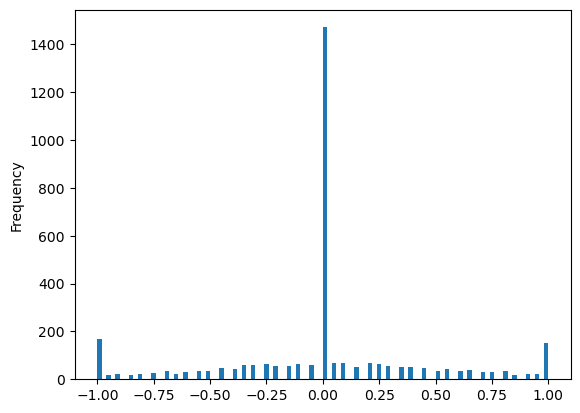

In [4]:
df['steering'].plot.hist(bins=100)

In [5]:
df['steering'].describe()

count    3404.000000
mean        0.006287
std         0.448691
min        -1.000000
25%        -0.100000
50%         0.000000
75%         0.150000
max         1.000000
Name: steering, dtype: float64

<Axes: ylabel='Frequency'>

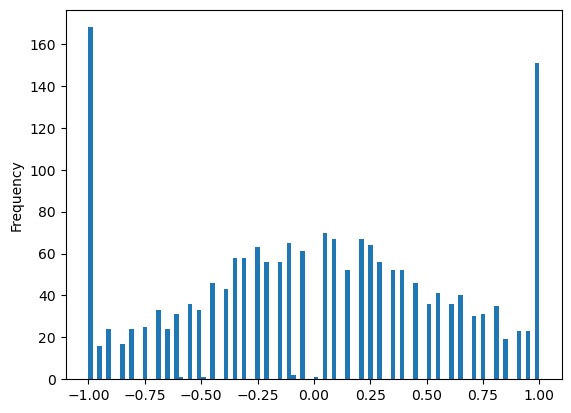

In [6]:
non_zero = df[df['steering'] != 0]
non_zero['steering'].plot.hist(bins=100)

In [7]:
zero_df = df[df['steering'] == 0].sample(frac=0.05)
print(len(zero_df))

74


In [8]:
df_train = pd.concat([non_zero, zero_df])
print(len(df_train))

2007


<Axes: ylabel='Frequency'>

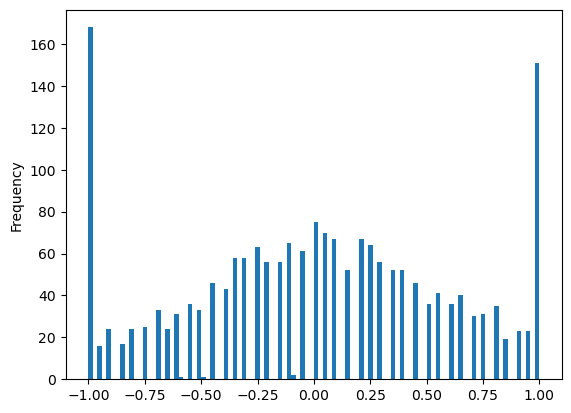

In [9]:
df_train['steering'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

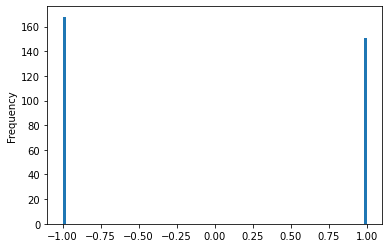

In [66]:
df_extreme = df_train[(df_train['steering'] > 0.99) | (df_train['steering'] < -0.99)]
df_extreme['steering'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

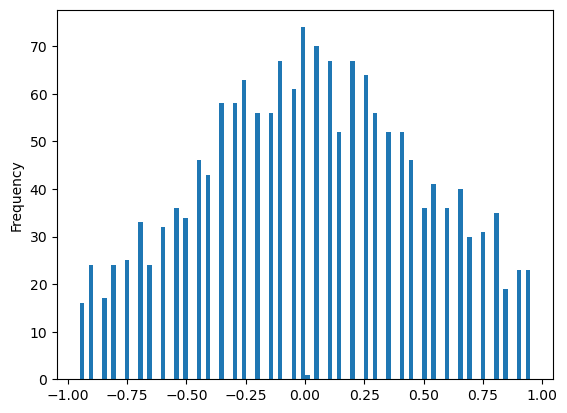

In [10]:
df_train = df_train[(df_train['steering'] < 0.99) & (df_train['steering'] > -0.99)]
df_train['steering'].plot.hist(bins=100)

In [11]:
X, y = [], []
for img_path, steer in zip(df_train['center'], df_train['steering']):
    img = np.asarray(Image.open(img_path))
    X.append(img)
    y.append(steer)
    
X = np.array(X) / 255.0
y = np.array(y)
X_flipped = np.array([np.fliplr(i) for i in X])
y_flipped = np.array([-i for i in y])
X = np.concatenate([X, X_flipped])
y = np.concatenate([y, y_flipped])
print(X.shape, y.shape)

(3376, 160, 320, 3) (3376,)


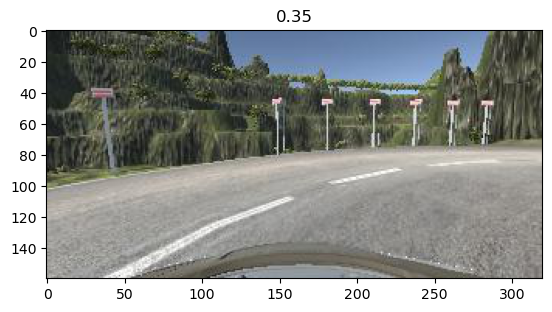

In [12]:
i = np.random.randint(0, len(X))
plt.imshow(X[i])
plt.title(y[i])
plt.show()

In [15]:
##  Print stats of X and y
print(f'X shape: {X.shape}, y shape: {y.shape}')
print(f'X dtype: {X.dtype}, y dtype: {y.dtype}')
print(f'X mean: {X.mean()}, y mean: {y.mean()}')
print(f'X std: {X.std()}, y std: {y.std()}')
print(f'X min: {X.min()}, y min: {y.min()}')
print(f'X max: {X.max()}, y max: {y.max()}')


X shape: (3376, 160, 320, 3), y shape: (3376,)
X dtype: float64, y dtype: float64
X mean: 0.4008341908769957, y mean: 0.0
X std: 0.21428614324224068, y std: 0.46579703839620806
X min: 0.0, y min: -0.9500002
X max: 1.0, y max: 0.9500002


#  Train

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
)

datagen_train = datagen.flow(X, y, batch_size=32, shuffle=True, seed=42, subset='training', ignore_class_split=True)
datagen_val = datagen.flow(X, y, batch_size=32, shuffle=True, seed=42, subset='validation', ignore_class_split=True)

(32, 160, 320, 3)


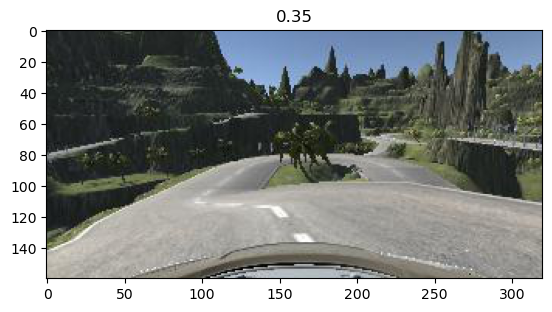

In [17]:
temp = datagen_train.next()
print(temp[0].shape)
plt.imshow(temp[0][0])
plt.title(y[i])
plt.show()

In [18]:
data_augmentation = Sequential(
    [
        RandomContrast(0.5),
    ]
)

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 32.00 GB
maxCacheSize: 3.99 GB



2023-05-31 13:27:40.605087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-31 13:27:40.605137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
model = tf.keras.Sequential([
    layers.Input(shape=(160, 320, 3)),
    # data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [20]:
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 320, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 160, 16)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 80, 160, 16)      64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 160, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 80, 32)       0         
 2D)                                                             
                                                      

In [21]:
model_name = 'mh_dave2_udacity'
ckpt = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)
model.fit(datagen_train, epochs=15,
          validation_data=datagen_val, callbacks=[ckpt])

Epoch 1/15


2023-05-31 13:27:45.081035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-31 13:27:46.742668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - ETA: 0s - loss: 0.7600

2023-05-31 13:28:10.500201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-31 13:28:10.652630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.87717, saving model to mh_dave2_udacity


2023-05-31 13:28:12.558125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]
2023-05-31 13:28:13.222660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


85/85 [==============================] - 31s 255ms/step - loss: 0.7600 - val_loss: 0.8772
Epoch 2/15
85/85 [==============================] - ETA: 0s - loss: 0.2708
Epoch 2: val_loss did not improve from 0.87717
85/85 [==============================] - 11s 132ms/step - loss: 0.2708 - val_loss: 0.9711
Epoch 3/15
85/85 [==============================] - ETA: 0s - loss: 0.2408
Epoch 3: val_loss did not improve from 0.87717
85/85 [==============================] - 11s 132ms/step - loss: 0.2408 - val_loss: 0.9970
Epoch 4/15
85/85 [==============================] - ETA: 0s - loss: 0.2342
Epoch 4: val_loss improved from 0.87717 to 0.30039, saving model to mh_dave2_udacity


2023-05-31 13:28:50.394218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]
2023-05-31 13:28:50.979415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


85/85 [==============================] - 15s 176ms/step - loss: 0.2342 - val_loss: 0.3004
Epoch 5/15
85/85 [==============================] - ETA: 0s - loss: 0.2172
Epoch 5: val_loss improved from 0.30039 to 0.26347, saving model to mh_dave2_udacity


2023-05-31 13:29:05.314820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]
2023-05-31 13:29:06.176365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


85/85 [==============================] - 15s 178ms/step - loss: 0.2172 - val_loss: 0.2635
Epoch 6/15
85/85 [==============================] - ETA: 0s - loss: 0.2040
Epoch 6: val_loss improved from 0.26347 to 0.24369, saving model to mh_dave2_udacity


2023-05-31 13:29:20.420160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]
2023-05-31 13:29:21.302709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


85/85 [==============================] - 15s 178ms/step - loss: 0.2040 - val_loss: 0.2437
Epoch 7/15
85/85 [==============================] - ETA: 0s - loss: 0.2007
Epoch 7: val_loss did not improve from 0.24369
85/85 [==============================] - 11s 132ms/step - loss: 0.2007 - val_loss: 0.2454
Epoch 8/15
85/85 [==============================] - ETA: 0s - loss: 0.1983
Epoch 8: val_loss did not improve from 0.24369
85/85 [==============================] - 11s 133ms/step - loss: 0.1983 - val_loss: 0.2595
Epoch 9/15
85/85 [==============================] - ETA: 0s - loss: 0.1835
Epoch 9: val_loss did not improve from 0.24369
85/85 [==============================] - 11s 133ms/step - loss: 0.1835 - val_loss: 0.2575
Epoch 10/15
85/85 [==============================] - ETA: 0s - loss: 0.1721
Epoch 10: val_loss improved from 0.24369 to 0.23704, saving model to mh_dave2_udacity


2023-05-31 13:30:09.624778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]
2023-05-31 13:30:10.524892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


85/85 [==============================] - 15s 183ms/step - loss: 0.1721 - val_loss: 0.2370
Epoch 11/15
85/85 [==============================] - ETA: 0s - loss: 0.1765
Epoch 11: val_loss did not improve from 0.23704
85/85 [==============================] - 11s 133ms/step - loss: 0.1765 - val_loss: 0.2413
Epoch 12/15
85/85 [==============================] - ETA: 0s - loss: 0.1727
Epoch 12: val_loss did not improve from 0.23704
85/85 [==============================] - 11s 132ms/step - loss: 0.1727 - val_loss: 0.2425
Epoch 13/15
85/85 [==============================] - ETA: 0s - loss: 0.1642
Epoch 13: val_loss did not improve from 0.23704
85/85 [==============================] - 11s 132ms/step - loss: 0.1642 - val_loss: 0.2517
Epoch 14/15
85/85 [==============================] - ETA: 0s - loss: 0.1517
Epoch 14: val_loss did not improve from 0.23704
85/85 [==============================] - 11s 133ms/step - loss: 0.1517 - val_loss: 0.2422
Epoch 15/15
85/85 [==============================] - E

In [22]:
model.evaluate(datagen_val)

 5/22 [=====>........................] - ETA: 0s - loss: 0.2500

2023-05-31 13:31:12.401007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


22/22 [==============================] - 1s 27ms/step - loss: 0.2490


0.24901138246059418

In [23]:
model.save(model_name)

2023-05-31 13:31:16.938111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]
2023-05-31 13:31:17.619004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,20,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets


INFO:tensorflow:Assets written to: mh_dave2_udacity/assets
